In [1]:
!pip install -Uqq fastai
!pip install -Uqq fastai duckduckgo_search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 40.4 MB/s eta 0:00:0000:0100:01


In [3]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [4]:
from duckduckgo_search import DDGS

from fastcore.all import *
def search_images(keywords, max_images = 30):
    print(f"Searching for {keywords}")
    return L(DDGS().images(keywords,max_results=max_images)).itemgot('image')

In [5]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for bird photos


'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

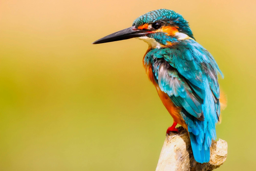

In [6]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for forest photos


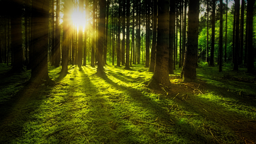

In [7]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [8]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)


Searching for forest photo
Searching for forest sun photo
Searching for forest shade photo
Searching for bird photo
Searching for bird sun photo
Searching for bird shade photo


In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

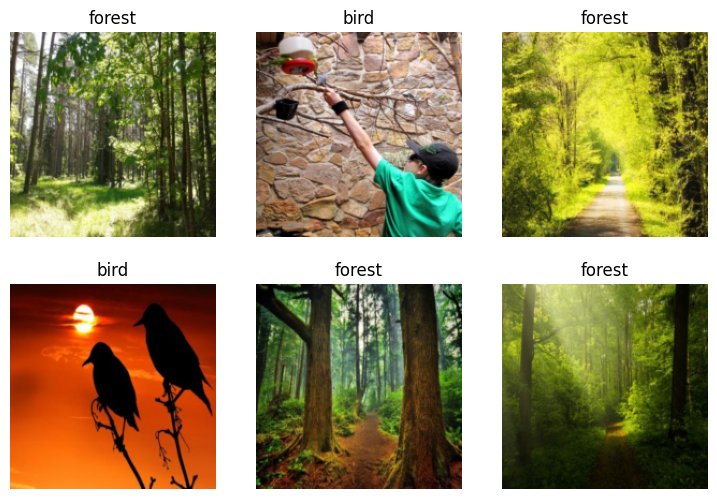

In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,0.877669,0.872015,0.352941,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.147910,0.070656,0.029412,00:14
1,0.110991,0.019875,0.000000,00:14
2,0.071884,0.029452,0.000000,00:18


In [12]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it is a bird: {probs[0]:.4f}")

This is a: bird.
Probability it is a bird: 1.0000
